In [81]:
import zipfile
import os

# Specify the uploaded zip file name (adjust according to the uploaded file)
zip_file_name = '/data.zip'  # Replace with the actual file name
extraction_path = '/content'  # Directory where you want to extract the files

# Ensure the extraction directory exists
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [107]:
import os
import random
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [108]:
# Paths to image and label directories
image_folder = '/content/data/images'
label_folder = '/content/data/labels'

# Get list of files in the directory
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])
label_files = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])

# Extract base filenames (without extensions) for comparison
image_basenames = {os.path.splitext(f)[0] for f in image_files}
label_basenames = {os.path.splitext(f)[0] for f in label_files}

# Find unmatched labels and remove them
unmatched_labels = label_basenames - image_basenames

for label_file in unmatched_labels:
    label_path = os.path.join(label_folder, f"{label_file}.png")
    try:
        os.remove(label_path)
        print(f"Removed unmatched label: {label_path}")
    except FileNotFoundError:
        print(f"File not found: {label_path}")

print("Unmatched labels removed.")

Unmatched labels removed.


In [109]:
# Resize image and label
def resize_image_and_label(image_path, label_path, target_size=(128, 128)):
    image = Image.open(image_path)
    label = Image.open(label_path)
    image = image.resize(target_size, Image.BILINEAR)
    label = label.resize(target_size, Image.NEAREST)
    return np.array(image), np.array(label)

# Normalize image
def normalize_image(image):
    image = image.astype(np.float32)
    image /= image.max()  # Normalize to [0, 1]
    return image

# One-hot encode labels for water mask in channel 11
def one_hot_encode_labels(label, num_classes):
    one_hot = np.zeros((*label.shape, num_classes), dtype=np.float32)
    # Assume channel 11 represents the water mask
    one_hot[..., 0] = (label == 11).astype(np.float32)
    return one_hot

# Data augmentation
def augment_data(image, label):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )
    image = np.expand_dims(image, 0)
    label = np.expand_dims(label, 0)
    for img_batch, lbl_batch in zip(datagen.flow(image), datagen.flow(label)):
        augmented_image = img_batch[0]
        augmented_label = lbl_batch[0]
        break
    return augmented_image, augmented_label


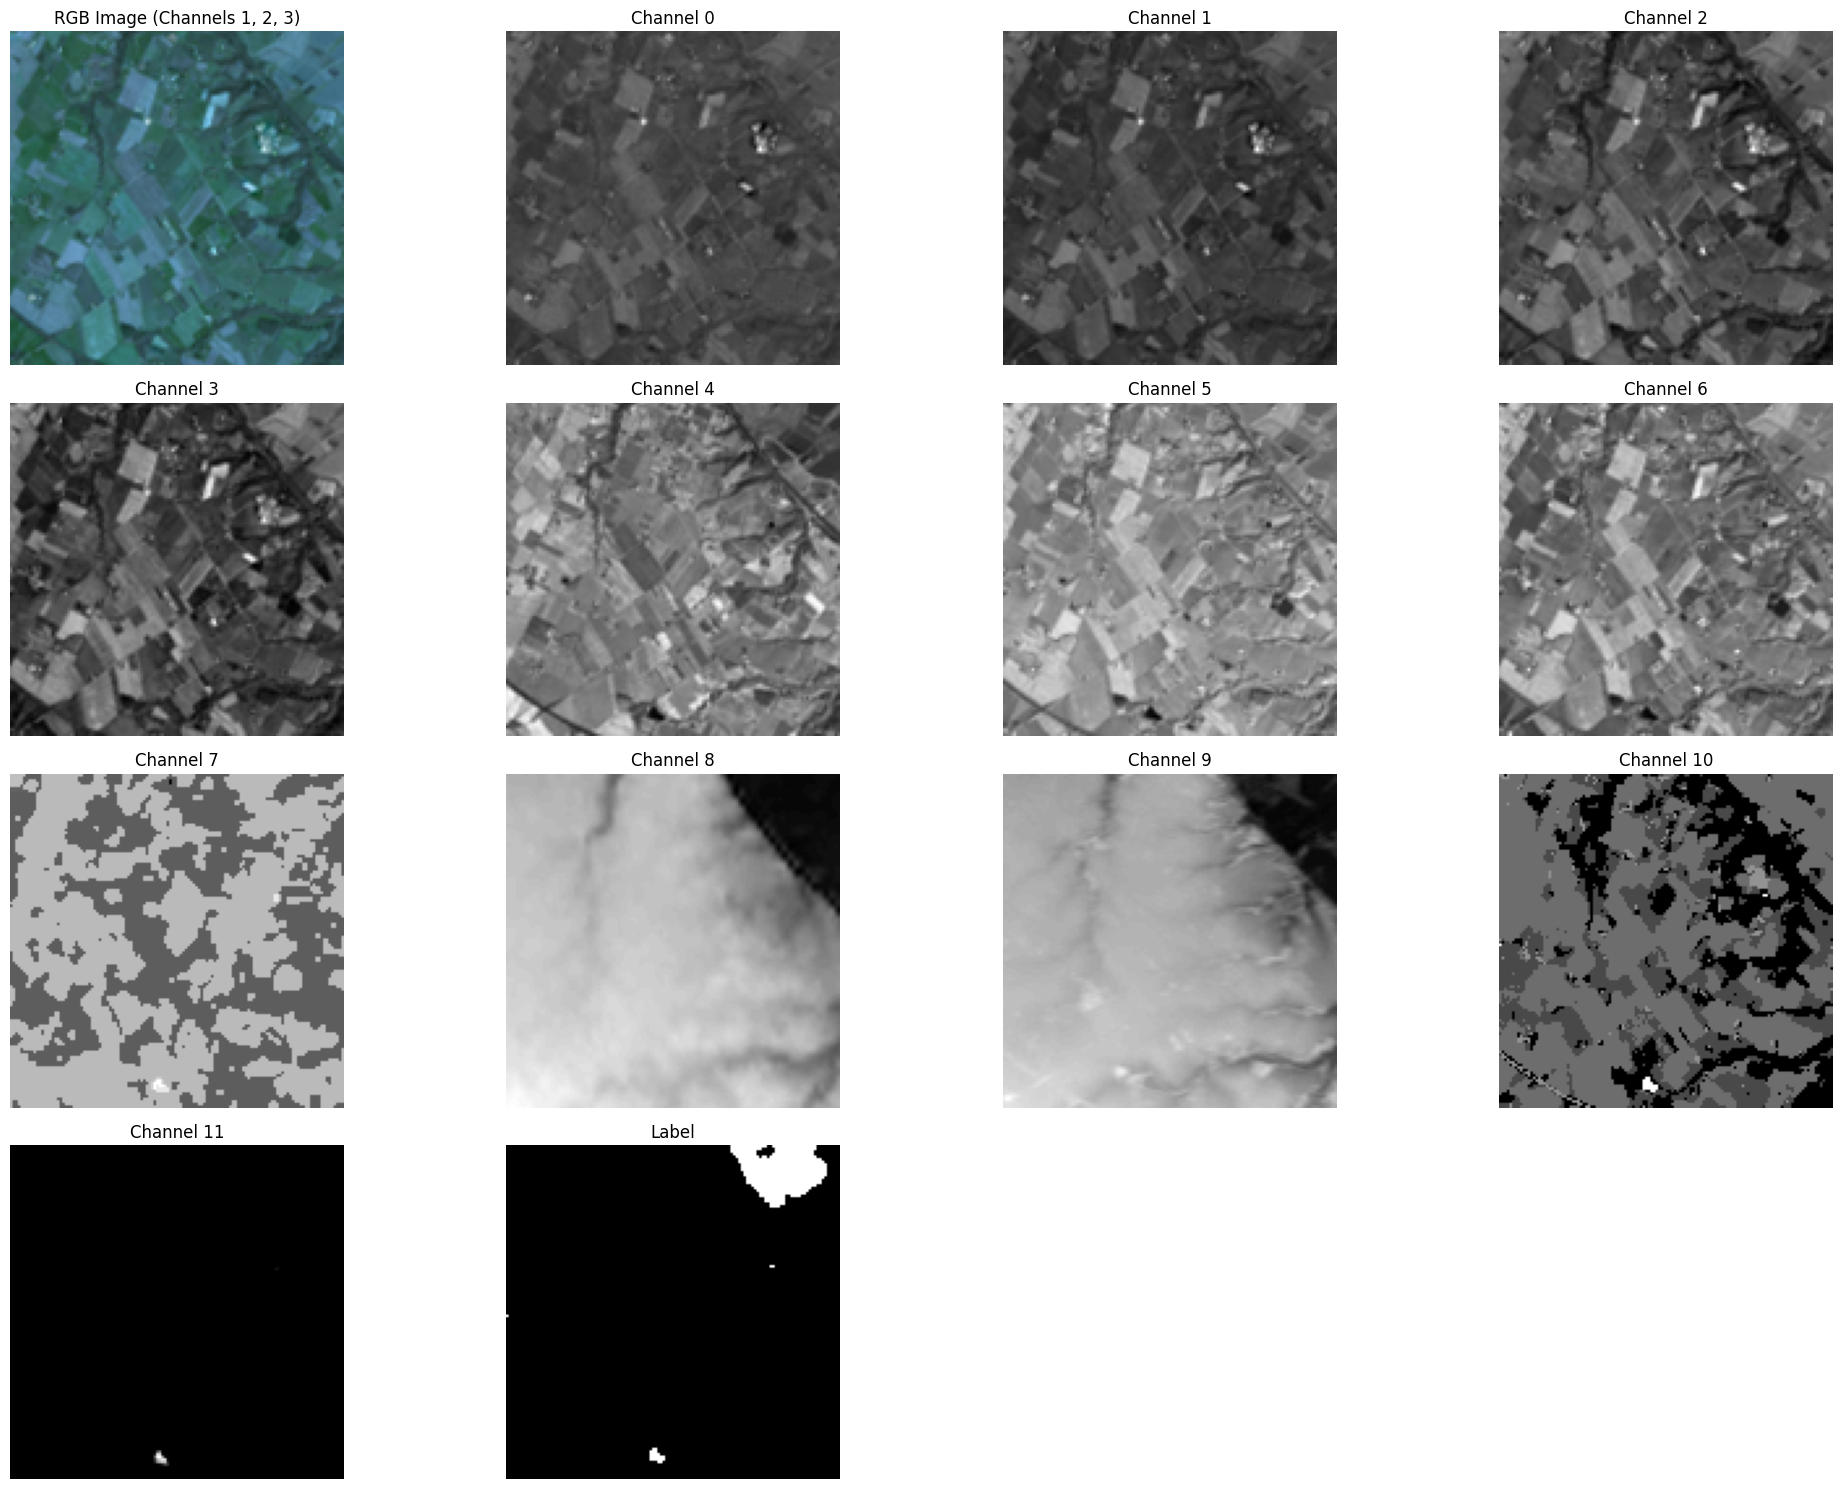

<ipython-input-110-c02afb85b6b1>:26: RuntimeWarning: invalid value encountered in divide
  image_channel = image_channel.astype(np.float32) / image_channel.max()


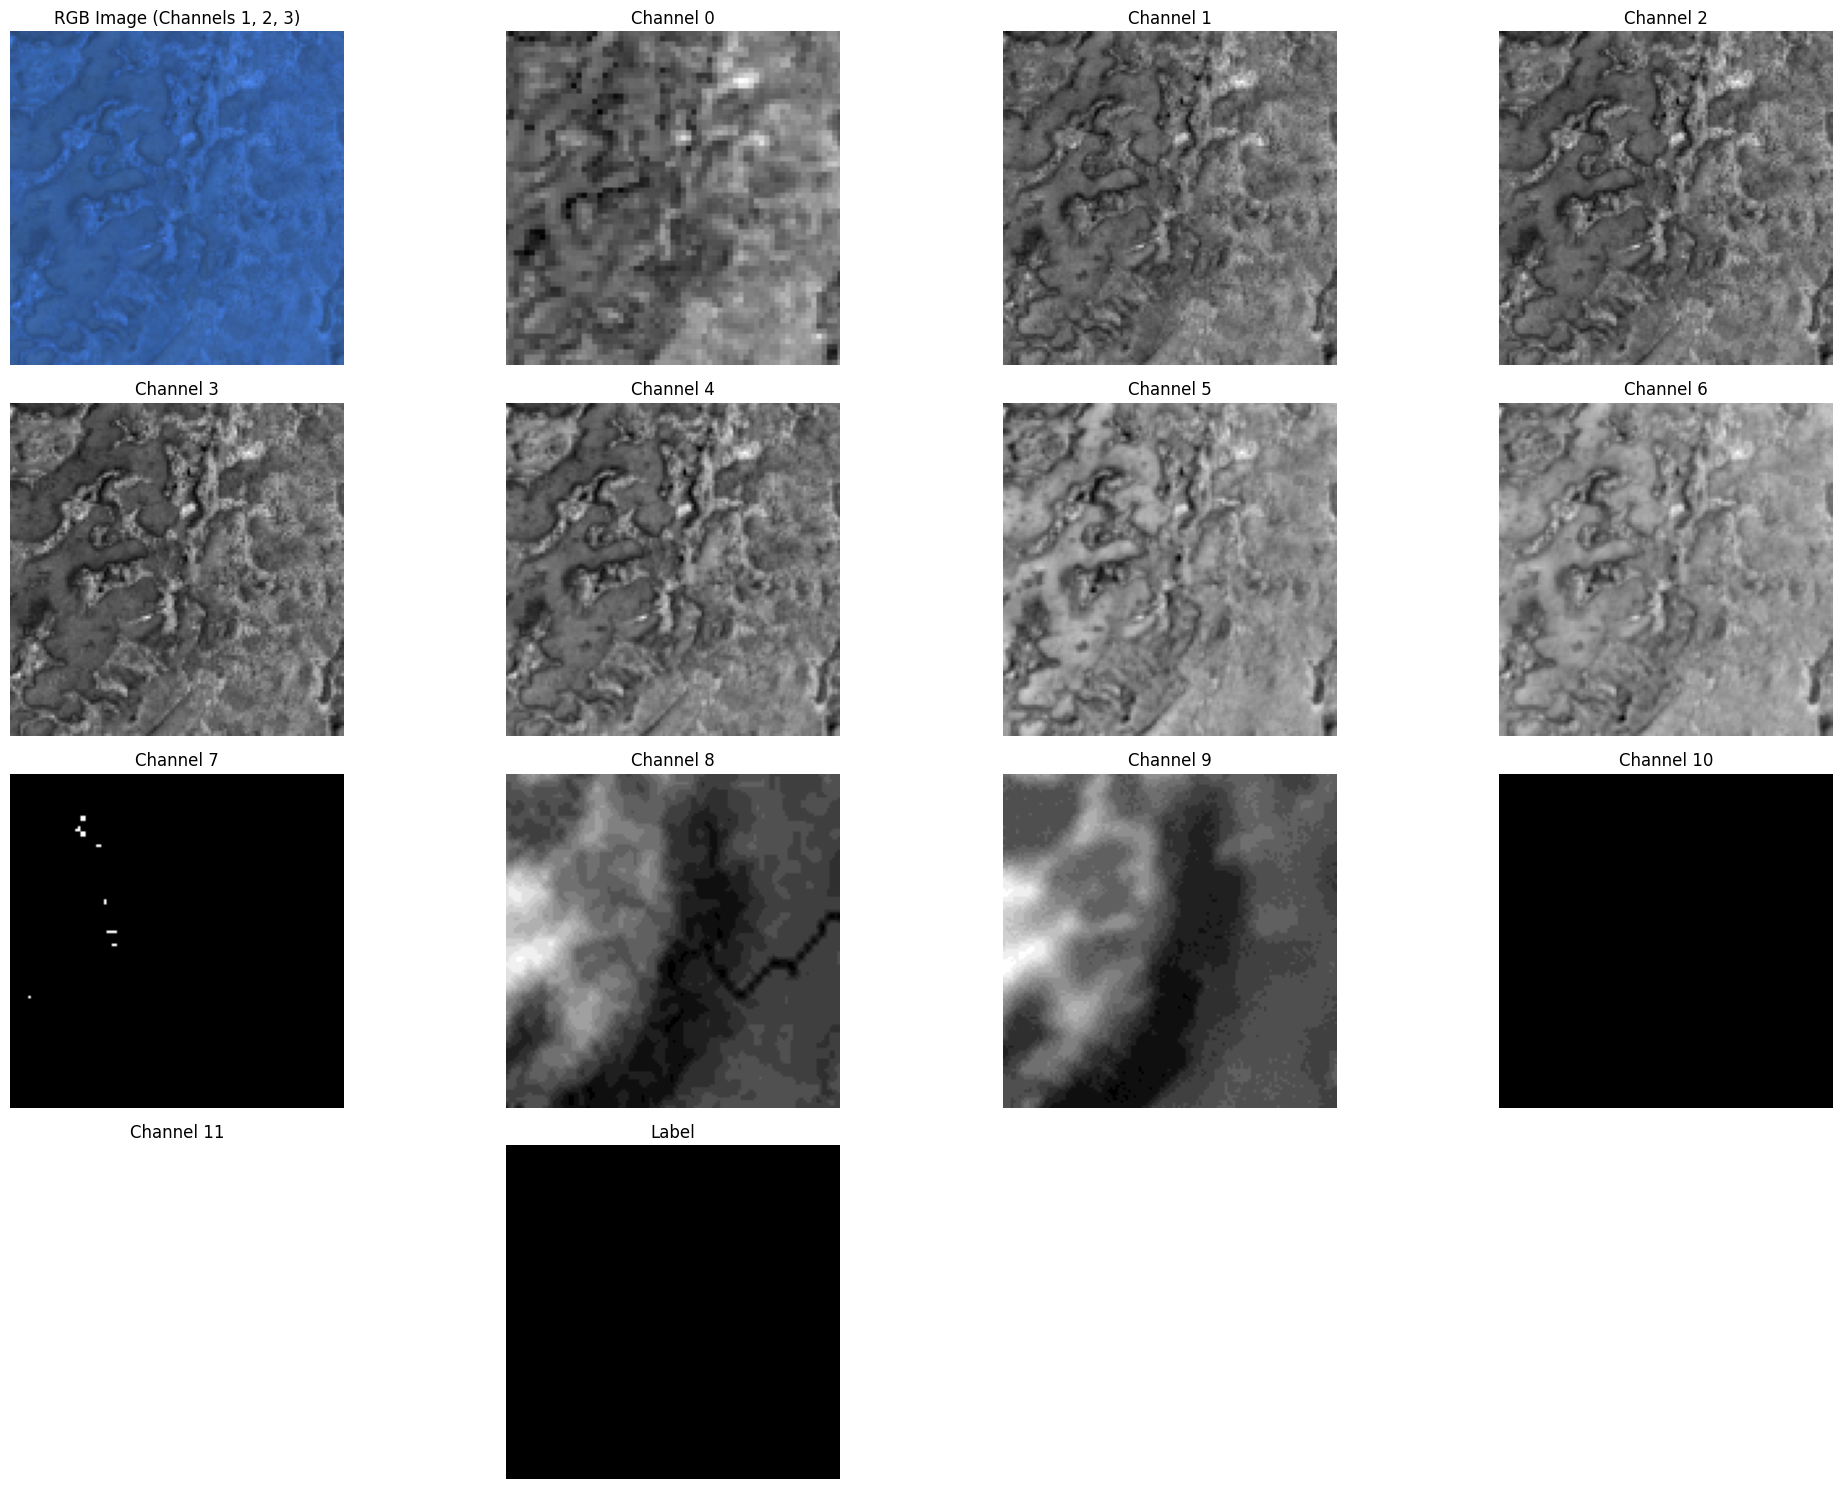

In [110]:
# Randomly select 2 images
selected_indices = random.sample(range(len(image_files)), 2)

# Function to visualize each channel and RGB channels with the label
def visualize_image_and_label(image_path, label_path):
    # Load the image using tifffile
    image = tiff.imread(image_path)
    num_channels = image.shape[-1]  # Get the number of channels
    num_rows = 4
    num_cols = 4

    plt.figure(figsize=(20, 15))

    # Display the RGB image (assuming channels 1, 2, and 3 are RGB)
    if num_channels > 3:
        rgb_image = np.stack([image[..., 1], image[..., 2], image[..., 3]], axis=-1)
        rgb_image = rgb_image.astype(np.float32) / rgb_image.max()
        plt.subplot(num_rows, num_cols, 1)
        plt.imshow(rgb_image)
        plt.title('RGB Image (Channels 1, 2, 3)')
        plt.axis('off')

    # Display each channel individually
    for i in range(num_channels):
        image_channel = image[..., i]
        image_channel = image_channel.astype(np.float32) / image_channel.max()
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(image_channel, cmap='gray')
        plt.title(f'Channel {i}')
        plt.axis('off')

    # Load and display the label
    label = Image.open(label_path)
    label = np.array(label)
    plt.subplot(num_rows, num_cols, num_channels + 2)
    plt.imshow(label, cmap='gray')
    plt.title('Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the randomly selected images
for idx in selected_indices:
    img_path = os.path.join(image_folder, image_files[idx])
    lbl_path = os.path.join(label_folder, label_files[idx])
    visualize_image_and_label(img_path, lbl_path)

In [111]:
num_images = len(image_files)
num_labels = len(label_files)
num_images, num_labels

(306, 306)

In [112]:
# Build U-Net model from scratch
def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [116]:
from PIL import Image
import numpy as np

def resize_image_and_label(image_path, label_path, target_size=(128, 128)):
    image = Image.open(image_path)
    label = Image.open(label_path)

    # Resize image and label
    image = image.resize(target_size, Image.BILINEAR)
    label = label.resize(target_size, Image.NEAREST)

    return np.array(image), np.array(label)


In [117]:
import tensorflow as tf

def iou_metric(y_true, y_pred, num_classes):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions

    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2]) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())

    return tf.reduce_mean(iou)


In [118]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[lambda y_true, y_pred: iou_metric(y_true, y_pred, num_classes)]
)


In [121]:
# Ensure X_train, y_train, and X_val are correctly defined and populated with data

# If using a validation set:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# If not using a validation set:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

KeyError: 'pop from an empty set'

In [ ]:
# Load the trained model
model = load_model(model_path, compile=False)

# Function to predict the mask from an image
def predict_mask(image):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    return prediction[0]  # Remove batch dimension

# Visualize the image, label, and prediction
def visualize_data_label_prediction(image, label, prediction, num_channels):
    num_rows = num_channels + 2
    num_cols = 4

    plt.figure(figsize=(20, 15))

    # Display the RGB image (assuming channels 1, 2, and 3 are RGB)
    if num_channels > 3:
        rgb_image = np.stack([image[..., 1], image[..., 2], image[..., 3]], axis=-1)
        rgb_image = rgb_image.astype(np.float32) / rgb_image.max()
        plt.subplot(num_rows, num_cols, 1)
        plt.imshow(rgb_image)
        plt.title('RGB Image (Channels 1, 2, 3)')
        plt.axis('off')

    # Display each channel individually
    for i in range(num_channels):
        image_channel = image[..., i]
        image_channel = image_channel.astype(np.float32) / image_channel.max()
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(image_channel, cmap='gray')
        plt.title(f'Channel {i}')
        plt.axis('off')

    # Display the label
    plt.subplot(num_rows, num_cols, num_channels + 2)
    plt.imshow(label, cmap='gray')
    plt.title('Label')
    plt.axis('off')

    # Display the prediction
    plt.subplot(num_rows, num_cols, num_channels + 3)
    plt.imshow(prediction, cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for a selected image
example_image_path = os.path.join(image_folder, image_files[0])
example_label_path = os.path.join(label_folder, label_files[0])

# Load and preprocess the example image and label
example_image = load_image(example_image_path)
example_label = Image.open(example_label_path)
example_label = np.array(example_label)

# Normalize the image
example_image = normalize_image(example_image)

# Predict mask
example_prediction = predict_mask(example_image)

# Visualize the image, label, and prediction
visualize_data_label_prediction(example_image, example_label, example_prediction, num_channels=example_image.shape[-1])
